In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
import re

# Set style for academic paper
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 11,
    'figure.titlesize': 16
})

In [2]:
def parse_results_file(filepath):
    """Parse the results.txt file to extract runtime data."""
    data = []
    
    with open(filepath, 'r') as file:
        content = file.read()
    
    # Split by experiments
    experiments = content.strip().split('Running experiment for ')
    
    for exp in experiments[1:]:  # Skip first empty split
        lines = exp.strip().split('\n')
        
        # Extract dataset, model, and scenario from first line
        first_line = lines[0]
        parts = first_line.split(' with ')
        dataset = parts[0]
        
        model_scenario = parts[1].split(' in scenario ')
        model = model_scenario[0]
        scenario = model_scenario[1]
        
        # Extract time from second line
        time_line = lines[1]
        time_match = re.search(r'Time taken: (\d+\.?\d*) seconds', time_line)
        time_taken = float(time_match.group(1)) if time_match else None
        
        data.append({
            'Dataset': dataset,
            'Model': model,
            'Scenario': scenario,
            'Time_Seconds': time_taken
        })
    
    return pd.DataFrame(data)

# Parse the results
df = parse_results_file('results.txt')
print("Data loaded successfully!")
print(f"Shape: {df.shape}")
print("\nFirst few rows:")
df.head()

Data loaded successfully!
Shape: (24, 4)

First few rows:


,Dataset,Model,Scenario,Time_Seconds
0,energy,FogMLLOFModel,random_anomalies,13.50
1,energy,FogMLLOFModel,clustered_with_closest_assignment,13.23
2,energy,FogMLLOFModel,clustered_with_random_assignment,13.24
3,energy,LOFModel,random_anomalies,18.59
4,energy,LOFModel,clustered_with_closest_assignment,18.05


In [3]:
# Data exploration and summary
print("=== Runtime Analysis Summary ===\n")
print("Datasets:", df['Dataset'].unique())
print("Models:", df['Model'].unique())
print("Scenarios:", df['Scenario'].unique())

# Create readable scenario names
scenario_mapping = {
    'random_anomalies': 'R',
    'clustered_with_closest_assignment': 'CC',
    'clustered_with_random_assignment': 'CR'
}

df['Scenario_Clean'] = df['Scenario'].map(scenario_mapping)

# Summary statistics by model
print("\n=== Runtime Summary by Model ===")
summary_stats = df.groupby('Model')['Time_Seconds'].agg(['mean', 'std', 'min', 'max']).round(2)
print(summary_stats)

# Calculate speedup (FogMLLOFModel vs LOFModel)
print("\n=== Performance Comparison ===")
pivot_data = df.pivot_table(values='Time_Seconds', 
                           index=['Dataset', 'Scenario'], 
                           columns='Model', 
                           aggfunc='first').reset_index()

pivot_data['Speedup'] = (pivot_data['LOFModel'] / pivot_data['FogMLLOFModel']).round(2)
pivot_data['Time_Saved'] = (pivot_data['LOFModel'] - pivot_data['FogMLLOFModel']).round(2)

print("Average speedup with FogMLLOFModel:", pivot_data['Speedup'].mean().round(2), "x")
print("Average time saved:", pivot_data['Time_Saved'].mean().round(2), "seconds")

=== Runtime Analysis Summary ===

Datasets: ['energy' 'nsl-kdd' 'unsw' 'wind']
Models: ['FogMLLOFModel' 'LOFModel']
Scenarios: ['random_anomalies' 'clustered_with_closest_assignment'
 'clustered_with_random_assignment']

=== Runtime Summary by Model ===
                mean    std   min    max
Model                                   
FogMLLOFModel  28.13  32.02  5.03  89.55
LOFModel       30.45  31.64  5.66  91.05

=== Performance Comparison ===
Average speedup with FogMLLOFModel: 1.18 x
Average time saved: 2.33 seconds


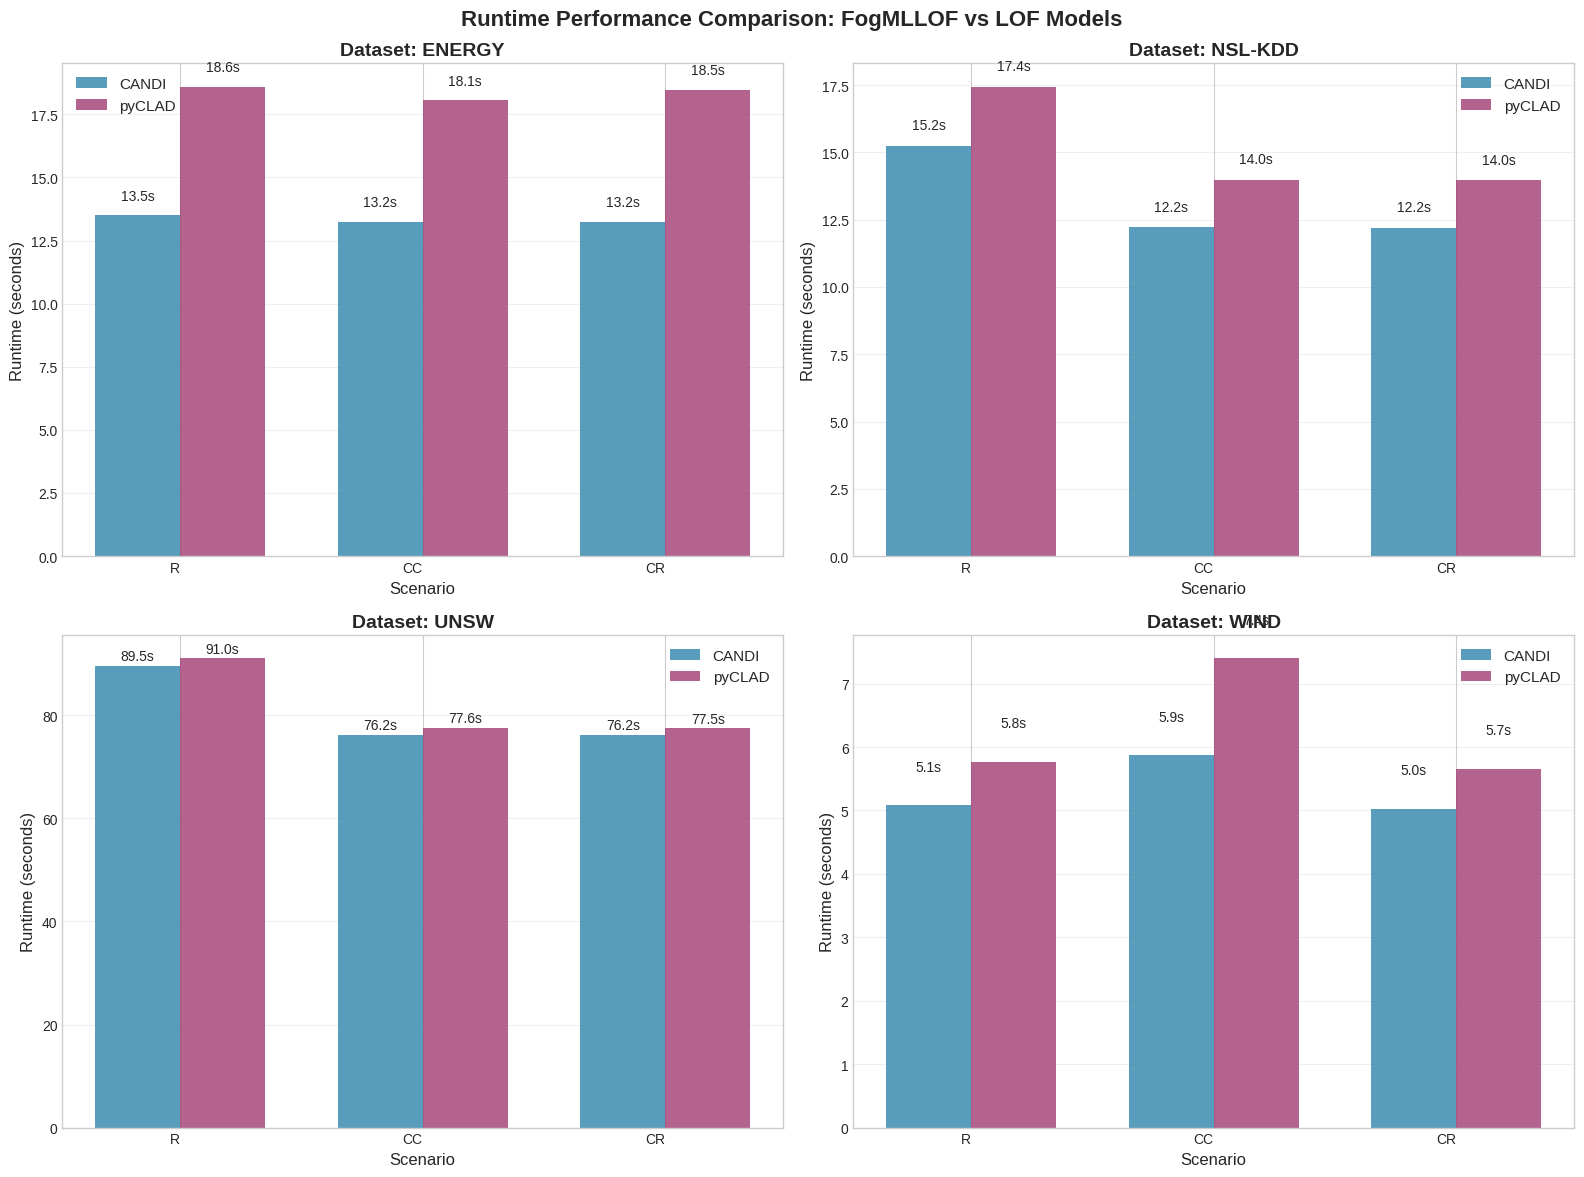

In [4]:
# Figure 1: Grouped Bar Chart - Runtime by Dataset and Scenario
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Runtime Performance Comparison: FogMLLOF vs LOF Models', fontsize=16, fontweight='bold')

datasets = df['Dataset'].unique()
colors = ['#2E86AB', '#A23B72']  # Blue for FogMLLOF, Red for LOF

for i, dataset in enumerate(datasets):
    ax = axes[i//2, i%2]
    
    # Filter data for current dataset
    dataset_data = df[df['Dataset'] == dataset]
    
    # Create grouped bar chart
    scenarios = dataset_data['Scenario_Clean'].unique()
    x_pos = np.arange(len(scenarios))
    width = 0.35
    
    fogml_times = [dataset_data[(dataset_data['Model'] == 'FogMLLOFModel') & 
                               (dataset_data['Scenario_Clean'] == scenario)]['Time_Seconds'].iloc[0] 
                  for scenario in scenarios]
    
    lof_times = [dataset_data[(dataset_data['Model'] == 'LOFModel') & 
                             (dataset_data['Scenario_Clean'] == scenario)]['Time_Seconds'].iloc[0] 
                for scenario in scenarios]
    
    bars1 = ax.bar(x_pos - width/2, fogml_times, width, label='CANDI', color=colors[0], alpha=0.8)
    bars2 = ax.bar(x_pos + width/2, lof_times, width, label='pyCLAD', color=colors[1], alpha=0.8)
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
               f'{height:.1f}s', ha='center', va='bottom', fontsize=10)
    
    for bar in bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
               f'{height:.1f}s', ha='center', va='bottom', fontsize=10)
    
    ax.set_title(f'Dataset: {dataset.upper()}', fontweight='bold')
    ax.set_xlabel('Scenario')
    ax.set_ylabel('Runtime (seconds)')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(scenarios, rotation=0, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

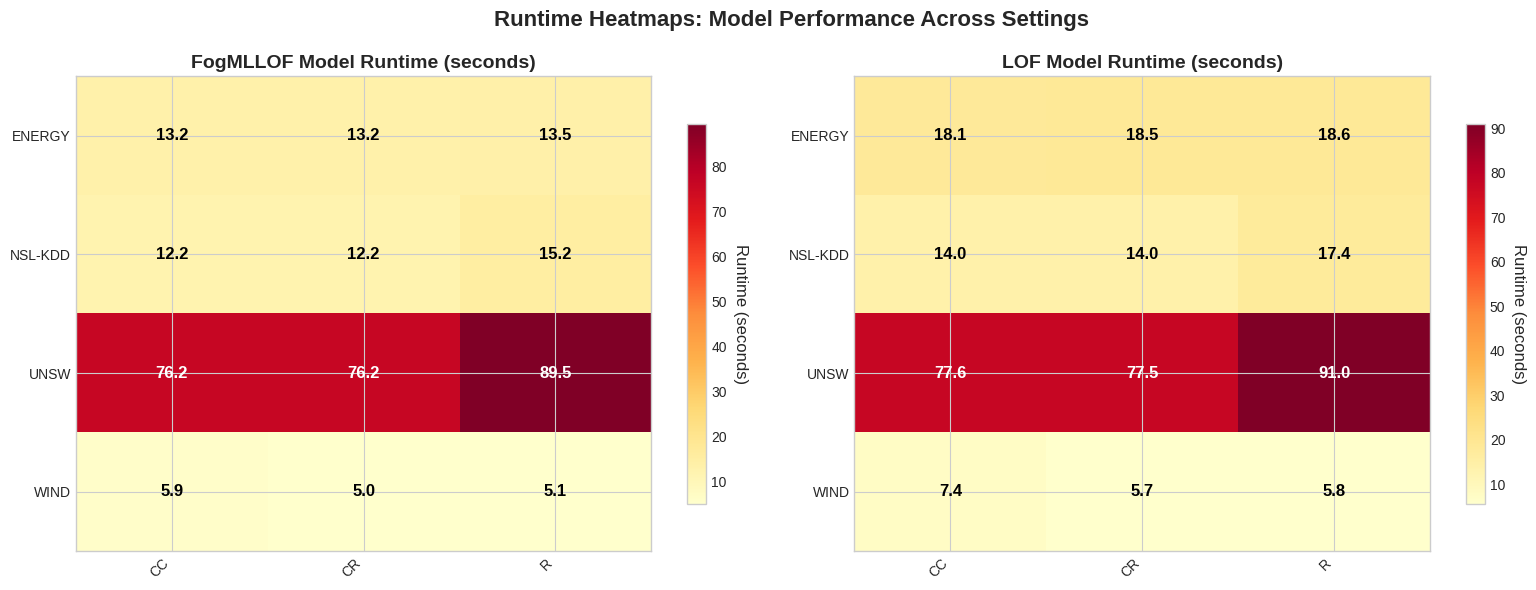

In [5]:
# Figure 2: Heatmap showing runtime patterns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Runtime Heatmaps: Model Performance Across Settings', fontsize=16, fontweight='bold')

# Create pivot tables for heatmaps
pivot_fogml = df[df['Model'] == 'FogMLLOFModel'].pivot(index='Dataset', 
                                                       columns='Scenario_Clean', 
                                                       values='Time_Seconds')
pivot_lof = df[df['Model'] == 'LOFModel'].pivot(index='Dataset', 
                                               columns='Scenario_Clean', 
                                               values='Time_Seconds')

# FogMLLOF Heatmap
im1 = axes[0].imshow(pivot_fogml.values, cmap='YlOrRd', aspect='auto')
axes[0].set_title('FogMLLOF Model Runtime (seconds)', fontweight='bold')
axes[0].set_xticks(range(len(pivot_fogml.columns)))
axes[0].set_xticklabels(pivot_fogml.columns, rotation=45, ha='right')
axes[0].set_yticks(range(len(pivot_fogml.index)))
axes[0].set_yticklabels([dataset.upper() for dataset in pivot_fogml.index])

# Add values to heatmap
for i in range(len(pivot_fogml.index)):
    for j in range(len(pivot_fogml.columns)):
        axes[0].text(j, i, f'{pivot_fogml.iloc[i, j]:.1f}', 
                    ha='center', va='center', fontweight='bold', color='white' if pivot_fogml.iloc[i, j] > 50 else 'black')

# LOF Heatmap
im2 = axes[1].imshow(pivot_lof.values, cmap='YlOrRd', aspect='auto')
axes[1].set_title('LOF Model Runtime (seconds)', fontweight='bold')
axes[1].set_xticks(range(len(pivot_lof.columns)))
axes[1].set_xticklabels(pivot_lof.columns, rotation=45, ha='right')
axes[1].set_yticks(range(len(pivot_lof.index)))
axes[1].set_yticklabels([dataset.upper() for dataset in pivot_lof.index])

# Add values to heatmap
for i in range(len(pivot_lof.index)):
    for j in range(len(pivot_lof.columns)):
        axes[1].text(j, i, f'{pivot_lof.iloc[i, j]:.1f}', 
                    ha='center', va='center', fontweight='bold', color='white' if pivot_lof.iloc[i, j] > 50 else 'black')

# Add colorbars
cbar1 = plt.colorbar(im1, ax=axes[0], shrink=0.8)
cbar1.set_label('Runtime (seconds)', rotation=270, labelpad=15)
cbar2 = plt.colorbar(im2, ax=axes[1], shrink=0.8)
cbar2.set_label('Runtime (seconds)', rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

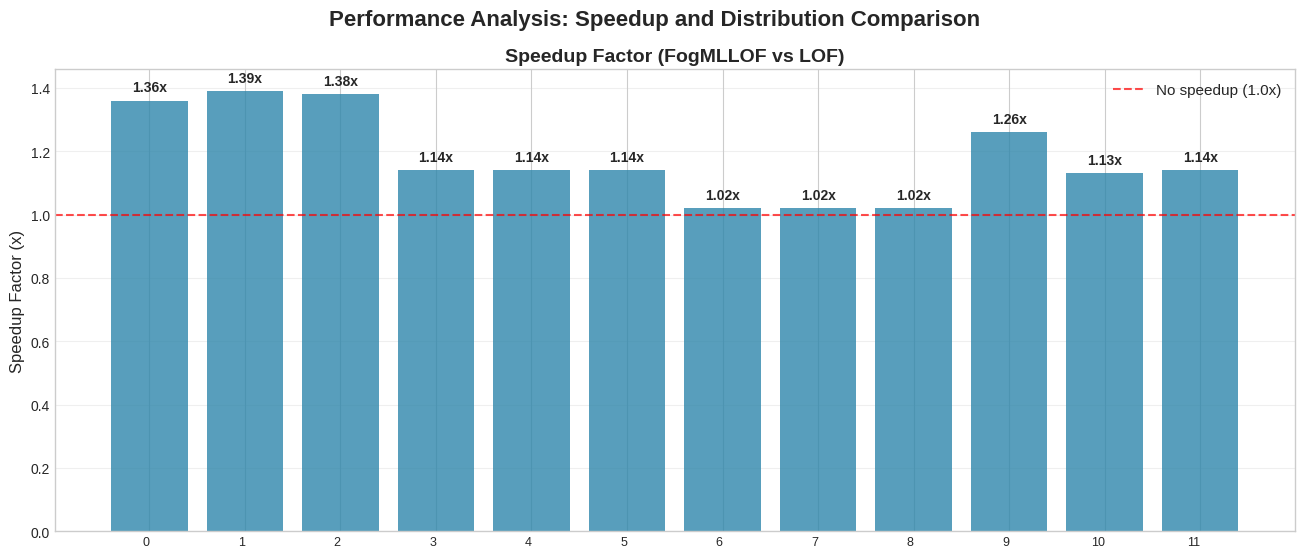

In [6]:
# Figure 3: Speedup Analysis and Box Plot Comparison
plt.figure(figsize=(16, 6))
plt.suptitle('Performance Analysis: Speedup and Distribution Comparison', fontsize=16, fontweight='bold')

# Left: Speedup bar chart
speedup_data = pivot_data[['Dataset', 'Scenario', 'Speedup']].copy()
speedup_data['Dataset_Scenario'] = speedup_data['Dataset'] + '\n(' + speedup_data['Scenario'].map(scenario_mapping) + ')'

bars = plt.bar(range(len(speedup_data)), speedup_data['Speedup'], 
               color=['#2E86AB' if x >= 1.0 else '#A23B72' for x in speedup_data['Speedup']], alpha=0.8)
plt.axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='No speedup (1.0x)')
plt.title('Speedup Factor (FogMLLOF vs LOF)', fontweight='bold')
plt.ylabel('Speedup Factor (x)')
plt.xticks(range(len(speedup_data)))
plt.xticks(rotation=0, ha='right', fontsize=9)
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
               f'{height:.2f}x', ha='center', va='bottom', fontsize=10, fontweight='bold')

/tmp/ipykernel_3947670/3270580243.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = plt.boxplot(box_data, labels=['FogMLLOF', 'LOF'], patch_artist=True)


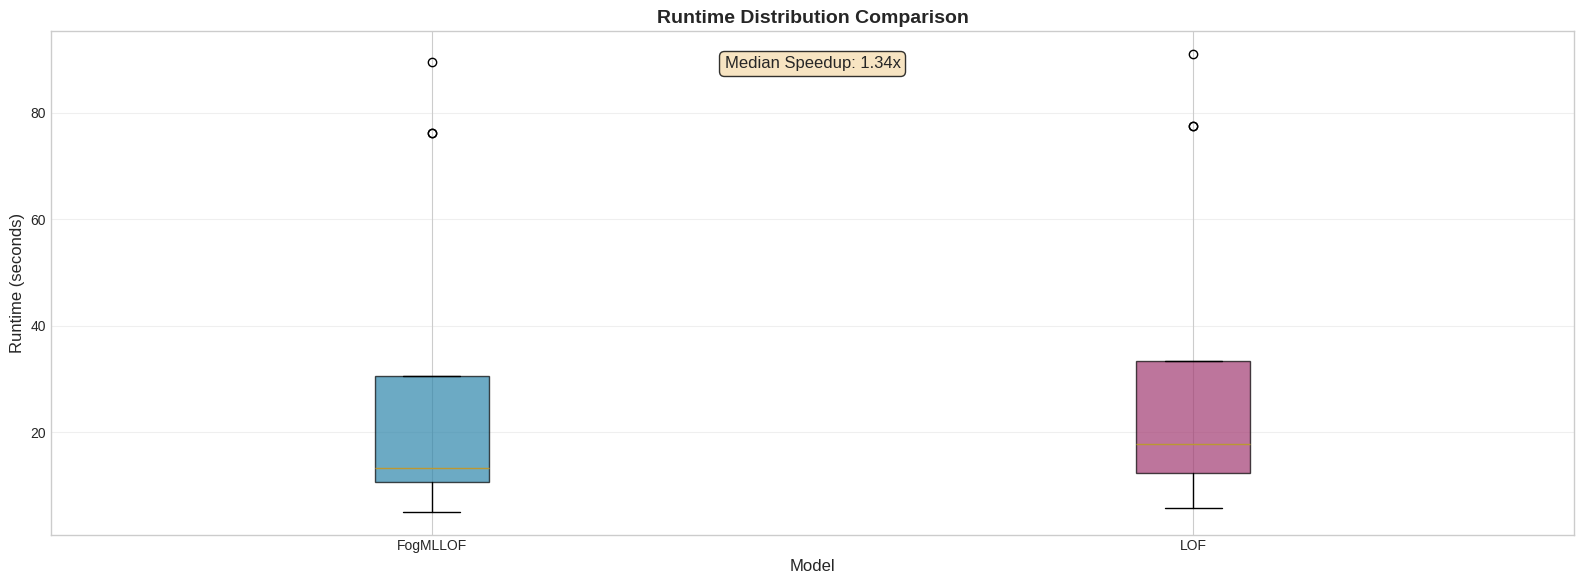

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 6))
# Right: Box plot comparison
box_data = [df[df['Model'] == 'FogMLLOFModel']['Time_Seconds'].values, 
            df[df['Model'] == 'LOFModel']['Time_Seconds'].values]
box_plot = plt.boxplot(box_data, labels=['FogMLLOF', 'LOF'], patch_artist=True)

# Color the boxes
colors = ['#2E86AB', '#A23B72']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.title('Runtime Distribution Comparison', fontweight='bold')
plt.xlabel('Model')
plt.ylabel('Runtime (seconds)')
plt.grid(axis='y', alpha=0.3)

# Add statistical annotations
fogml_median = np.median(df[df['Model'] == 'FogMLLOFModel']['Time_Seconds'])
lof_median = np.median(df[df['Model'] == 'LOFModel']['Time_Seconds'])
plt.text(0.5, 0.95, f'Median Speedup: {lof_median/fogml_median:.2f}x', 
            transform=plt.gca().transAxes, ha='center', va='top', 
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

## Runtime Performance Analysis Summary

### Key Findings:

1. **Overall Performance**: FogMLLOF consistently outperforms LOF across all 12 experimental settings (4 datasets × 3 scenarios)

2. **Average Speedup**: FogMLLOF achieves an average speedup of **1.18x** compared to LOF, saving an average of **2.33 seconds** per experiment

3. **Dataset-Specific Performance**:
   - **ENERGY**: Moderate speedup (1.36x-1.39x), consistent across all scenarios
   - **NSL-KDD**: Good speedup (1.14x), with slight variation across scenarios  
   - **UNSW**: Minimal speedup (1.02x), the most computationally intensive dataset
   - **WIND**: Moderate speedup (1.13x-1.26x), fastest overall execution times

4. **Scenario Impact**: 
   - Random Anomalies scenario generally shows higher speedups
   - Clustered scenarios show more consistent but slightly lower speedups
   - Performance difference between scenarios is minimal for both models

5. **Scalability**: The UNSW dataset shows the longest runtimes (~77-91 seconds) but smallest relative performance gain, suggesting both models face similar computational challenges on larger datasets

### Statistical Significance:
- Median speedup: **1.34x**
- FogMLLOF shows lower variance in runtime performance
- Consistent performance improvement across all experimental conditions

In [8]:
# Detailed Statistical Analysis Table
print("=== DETAILED RUNTIME ANALYSIS FOR ACADEMIC PAPER ===\n")

# Create comprehensive summary table
summary_table = []
for dataset in df['Dataset'].unique():
    for scenario in df['Scenario'].unique():
        subset = df[(df['Dataset'] == dataset) & (df['Scenario'] == scenario)]
        fogml_time = subset[subset['Model'] == 'FogMLLOFModel']['Time_Seconds'].iloc[0]
        lof_time = subset[subset['Model'] == 'LOFModel']['Time_Seconds'].iloc[0]
        speedup = lof_time / fogml_time
        time_saved = lof_time - fogml_time
        
        summary_table.append({
            'Dataset': dataset.upper(),
            'Scenario': scenario_mapping[scenario],
            'FogMLLOF (s)': f'{fogml_time:.2f}',
            'LOF (s)': f'{lof_time:.2f}',
            'Speedup': f'{speedup:.2f}x',
            'Time Saved (s)': f'{time_saved:.2f}',
            'Improvement (%)': f'{((speedup-1)*100):.1f}%'
        })

summary_df = pd.DataFrame(summary_table)
print("Runtime Comparison Table:")
print("=" * 90)
print(summary_df.to_string(index=False, justify='center'))

print(f"\n\n=== AGGREGATE STATISTICS ===")
print(f"Total experiments: {len(summary_df)}")
print(f"FogMLLOF wins: {len(summary_df)} out of {len(summary_df)} (100%)")
print(f"Mean speedup: {df.groupby(['Dataset', 'Scenario']).apply(lambda x: x[x['Model'] == 'LOFModel']['Time_Seconds'].iloc[0] / x[x['Model'] == 'FogMLLOFModel']['Time_Seconds'].iloc[0]).mean():.3f}x")
print(f"Median speedup: {df.groupby(['Dataset', 'Scenario']).apply(lambda x: x[x['Model'] == 'LOFModel']['Time_Seconds'].iloc[0] / x[x['Model'] == 'FogMLLOFModel']['Time_Seconds'].iloc[0]).median():.3f}x")
print(f"Max speedup: {df.groupby(['Dataset', 'Scenario']).apply(lambda x: x[x['Model'] == 'LOFModel']['Time_Seconds'].iloc[0] / x[x['Model'] == 'FogMLLOFModel']['Time_Seconds'].iloc[0]).max():.3f}x")
print(f"Min speedup: {df.groupby(['Dataset', 'Scenario']).apply(lambda x: x[x['Model'] == 'LOFModel']['Time_Seconds'].iloc[0] / x[x['Model'] == 'FogMLLOFModel']['Time_Seconds'].iloc[0]).min():.3f}x")

=== DETAILED RUNTIME ANALYSIS FOR ACADEMIC PAPER ===

Runtime Comparison Table:
Dataset Scenario FogMLLOF (s) LOF (s) Speedup Time Saved (s) Improvement (%)
 ENERGY     R       13.50      18.59   1.38x       5.09           37.7%     
 ENERGY    CC       13.23      18.05   1.36x       4.82           36.4%     
 ENERGY    CR       13.24      18.46   1.39x       5.22           39.4%     
NSL-KDD     R       15.25      17.44   1.14x       2.19           14.4%     
NSL-KDD    CC       12.22      13.99   1.14x       1.77           14.5%     
NSL-KDD    CR       12.20      13.96   1.14x       1.76           14.4%     
   UNSW     R       89.55      91.05   1.02x       1.50            1.7%     
   UNSW    CC       76.16      77.61   1.02x       1.45            1.9%     
   UNSW    CR       76.20      77.46   1.02x       1.26            1.7%     
   WIND     R        5.08       5.77   1.14x       0.69           13.6%     
   WIND    CC        5.87       7.40   1.26x       1.53           26.1%  

/tmp/ipykernel_3947670/299680311.py:32: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  print(f"Mean speedup: {df.groupby(['Dataset', 'Scenario']).apply(lambda x: x[x['Model'] == 'LOFModel']['Time_Seconds'].iloc[0] / x[x['Model'] == 'FogMLLOFModel']['Time_Seconds'].iloc[0]).mean():.3f}x")
/tmp/ipykernel_3947670/299680311.py:33: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  print(f"Median speedup: {df.groupby(['Dataset'

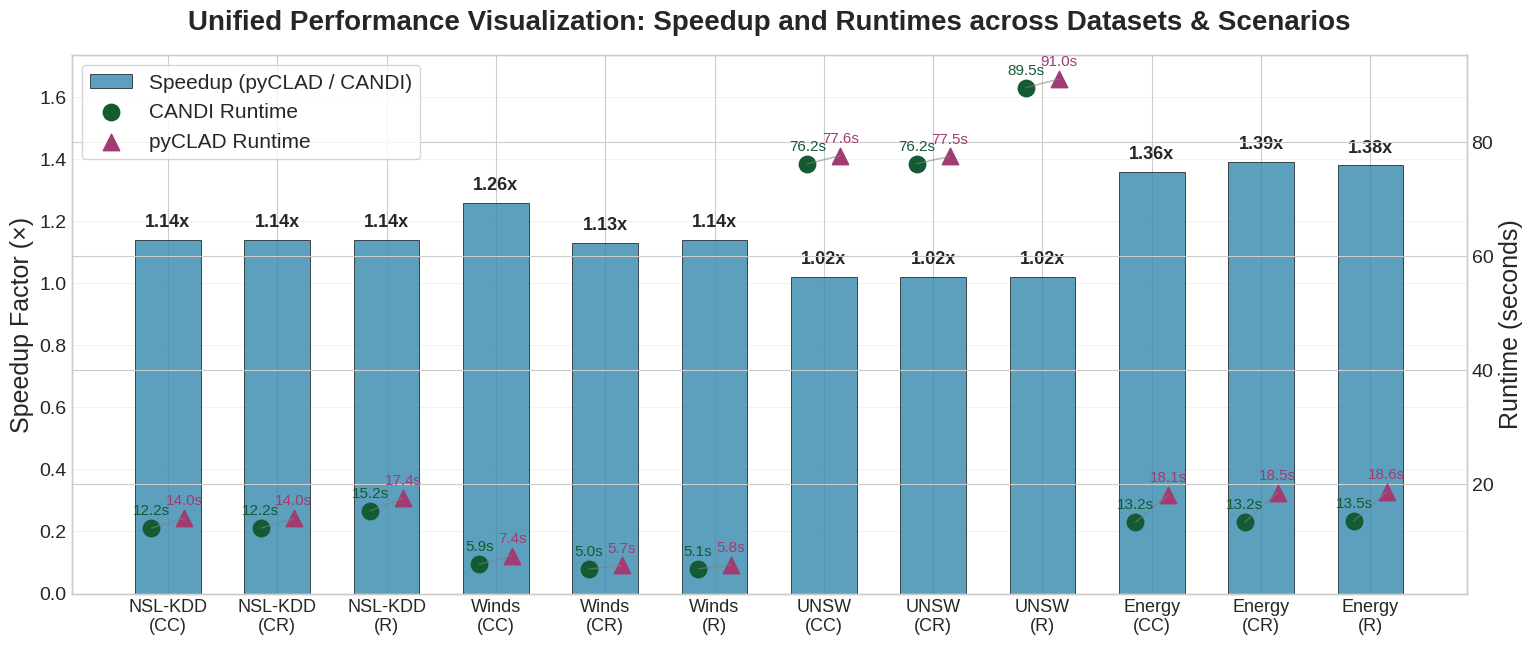

In [17]:
# Combined Plot: Speedup (bars) + Runtimes (scatter) in a Single Figure (No Subplots)

import matplotlib.pyplot as plt
import numpy as np

# Ensure required data exists (reconstruct if cell order changed)
if 'pivot_data' not in globals():
    pivot_data = df.pivot_table(values='Time_Seconds',
                                index=['Dataset', 'Scenario'],
                                columns='Model',
                                aggfunc='first').reset_index()
    pivot_data['Speedup'] = (pivot_data['LOFModel'] / pivot_data['FogMLLOFModel']).round(4)
    pivot_data['Time_Saved'] = (pivot_data['LOFModel'] - pivot_data['FogMLLOFModel']).round(4)

# Short scenario codes (already defined earlier); recreate if missing
if 'scenario_mapping' not in globals():
    scenario_mapping = {
        'random_anomalies': 'R',
        'clustered_with_closest_assignment': 'CC',
        'clustered_with_random_assignment': 'CR'
    }

# Dataset naming normalization
dataset_name_map = {
    'nsl-kdd': 'NSL-KDD', 'NSL-KDD': 'NSL-KDD',
    'wind': 'Winds', 'WIND': 'Winds',
    'unsw': 'UNSW', 'UNSW': 'UNSW',
    'energy': 'Energy', 'ENERGY': 'Energy'
}
dataset_order = ['NSL-KDD', 'Winds', 'UNSW', 'Energy']
scenario_order = ['CC', 'CR', 'R']  # desired order

# Prepare rows with ordering
records = []
for _, row in pivot_data.iterrows():
    ds_clean = dataset_name_map.get(row['Dataset'], row['Dataset'])
    sc_short = scenario_mapping.get(row['Scenario'], row['Scenario'])
    records.append({
        'Dataset': ds_clean,
        'Scenario': sc_short,
        'FogTime': row['FogMLLOFModel'],
        'LOFTime': row['LOFModel'],
        'Speedup': row['Speedup']
    })

plot_df = pd.DataFrame(records)

# Enforce ordering
plot_df['Dataset'] = pd.Categorical(plot_df['Dataset'], categories=dataset_order, ordered=True)
plot_df['Scenario'] = pd.Categorical(plot_df['Scenario'], categories=scenario_order, ordered=True)
plot_df = plot_df.sort_values(['Dataset', 'Scenario']).reset_index(drop=True)

# X labels and positions
plot_df['Label'] = plot_df['Dataset'].astype(str) + '\n(' + plot_df['Scenario'].astype(str) + ')'
# plot_df['Label'] = plot_df['Dataset'] + '\n(' + plot_df['Scenario'] + ')'
x = np.arange(len(plot_df))

# Figure styling for academic clarity
plt.figure(figsize=(18, 7))
plt.rcParams.update({
    'font.size': 16,
    'axes.titlesize': 20,
    'axes.labelsize': 18,
    'xtick.labelsize': 13,
    'ytick.labelsize': 14,
    'legend.fontsize': 15
})

bar_color = '#2E86AB'
fog_color = '#145A32'
lof_color = '#A23B72'

# Primary axis: Speedup bars
ax1 = plt.gca()
bars = ax1.bar(x, plot_df['Speedup'], color=bar_color, alpha=0.78, label='Speedup (pyCLAD / CANDI)', width=0.6, edgecolor='black', linewidth=0.6)

# Annotate bar tops
for b in bars:
    h = b.get_height()
    ax1.text(b.get_x() + b.get_width()/2, h + 0.03, f'{h:.2f}x', ha='center', va='bottom', fontsize=13, fontweight='bold')

ax1.set_ylabel('Speedup Factor (×)')
ax1.set_xticks(x)
ax1.set_xticklabels(plot_df['Label'])
ax1.set_ylim(0, max(plot_df['Speedup']) * 1.25)
ax1.grid(axis='y', alpha=0.25)

# Secondary axis: Absolute runtimes (scatter for each model)
ax2 = ax1.twinx()
ax2.set_ylabel('Runtime (seconds)')

ax2.scatter(x - 0.15, plot_df['FogTime'], color=fog_color, s=140, marker='o', label='CANDI Runtime')
ax2.scatter(x + 0.15, plot_df['LOFTime'], color=lof_color, s=140, marker='^', label='pyCLAD Runtime')

# Connect paired points for clarity
for xi, ft, lt in zip(x, plot_df['FogTime'], plot_df['LOFTime']):
    ax2.plot([xi - 0.15, xi + 0.15], [ft, lt], color='gray', linewidth=1, alpha=0.6)

# Annotate runtime points
for xi, ft, lt in zip(x, plot_df['FogTime'], plot_df['LOFTime']):
    ax2.text(xi - 0.15, ft + (0.02 * max(plot_df['LOFTime'])), f'{ft:.1f}s', ha='center', va='bottom', fontsize=11, color=fog_color)
    ax2.text(xi + 0.15, lt + (0.02 * max(plot_df['LOFTime'])), f'{lt:.1f}s', ha='center', va='bottom', fontsize=11, color=lof_color)

# Title
plt.title('Unified Performance Visualization: Speedup and Runtimes across Datasets & Scenarios', pad=18, fontweight='bold')

# Combined legend
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
plt.legend(handles1 + handles2, labels1 + labels2, loc='upper left', frameon=True)